# Hemoglobin Model Construction

Based on Chapter 13 of <cite data-cite="Pal11">Systems Biology: Simulation of Dynamic Network States</cite>

To construct a module of hemoglobin, first we import **MASSpy** and other essential packages. Constants used throughout the notebook are also defined.

In [1]:
from os import path

import matplotlib.pyplot as plt

from sympy import Equality, Symbol, solveset, sympify, pprint

from cobra import DictList

from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.test import create_test_model
from mass.io import json, sbml 
from mass.util import strip_time, qcqa_model

mass_config = MassConfiguration()

mass_config.irreversible_Keq = float("inf")

## Model Construction 

The first step of creating a model of hemoglobin is to define the `MassModel`. 

In [2]:
hemoglobin = MassModel("Hemoglobin")

### Metabolites

The next step is to define all of the metabolites using the `MassMetabolite` object. Some considerations for this step include the following:

1. It is important to use a clear and consistent format for identifiers and names when defining the `MassMetabolite` objects for various reasons, some of which include improvements to model clarity and utility, assurance of unique identifiers (required to add metabolites to the model), and consistency when collaborating and communicating with others. 

2. In order to ensure our model is physiologically accurate, it is important to provide the `formula` argument with a string representing the chemical formula for each metabolite, and the `charge` argument with an integer representing the metabolite's ionic charge (Note that neutrally charged metabolites are provided with 0). These attributes can always be set later if necessary using the `formula` and `charge` attribute set methods. To include the Hemoglobin macromolecule in the formula, brackets are used (e.g., [HB]).

3. To indicate that the cytosol is the cellular compartment in which the reactions occur, the string "c" is provided to the `compartment` argument.

This model will be created using identifiers and names found in the [BiGG Database](http://bigg.ucsd.edu/).

In this model, there are 13 metabolites inside the cytosol compartment. Note that for metabolites without BiGG identifiers are given ones that are similar to BiGG style. 

In [3]:
hb_c = MassMetabolite(
    "hb_c", 
    name="Hemoglobin", 
    formula="[HB]",
    charge=0,
    compartment="c",
    fixed=False)

hb_1o2_c = MassMetabolite(
    "hb_1o2_c", 
    name="Oxyhemoglobin (1)", 
    formula="[HB]-O2",
    charge=0,
    compartment="c",
    fixed=False)

hb_2o2_c = MassMetabolite(
    "hb_2o2_c", 
    name="Oxyhemoglobin (2)", 
    formula="[HB]-O4",
    charge=0,
    compartment="c",
    fixed=False)

hb_3o2_c = MassMetabolite(
    "hb_3o2_c", 
    name="Oxyhemoglobin (3)", 
    formula="[HB]-O6",
    charge=0,
    compartment="c",
    fixed=False)

hb_4o2_c = MassMetabolite(
    "hb_4o2_c", 
    name="Oxyhemoglobin (4)", 
    formula="[HB]-O8",
    charge=0,
    compartment="c",
    fixed=False)

dhb_c = MassMetabolite(
    "dhb_c", 
    name="Deoxyhemoglobin", 
    formula="[HB]-C3H3O10P2",
    charge=-5,
    compartment="c",
    fixed=False)

_23dpg_c = MassMetabolite(
    "_23dpg_c", 
    name="2,3-Disphospho-D-glycerate", 
    formula="C3H3O10P2",
    charge=-5,
    compartment="c",
    fixed=False)

_13dpg_c = MassMetabolite(
    "_13dpg_c",
    name="3-Phospho-D-glyceroyl phosphate",
    formula="C3H4O10P2",
    charge=-4,
    compartment="c",
    fixed=False)

_3pg_c = MassMetabolite(
    "_3pg_c",
    name="3-Phospho-D-glycerate",
    formula="C3H4O7P",
    charge=-3,
    compartment="c",
    fixed=False)

o2_c = MassMetabolite(
    "o2_c",
    name="Oxygen",
    formula="O2",
    charge=0,
    compartment="c",
    fixed=False)

h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c",
    fixed=False)

pi_c = MassMetabolite(
    "pi_c",
    name="Phosphate",
    formula="HPO4",
    charge=-2,
    compartment="c",
    fixed=False)

h2o_c = MassMetabolite(
    "h2o_c",
    name="H2O",
    formula="H2O",
    charge=0,
    compartment="c",
    fixed=False)

### Reactions

Once all of the `MassMetabolite` objects for each metabolite, the next step is to define all of the reactions that occur and their stoichiometry.

1. As with the metabolites, it is also important to use a clear and consistent format for identifiers and names when defining when defining the `MassReaction` objects.

2. To make this model useful for integration with other models, it is important to provide a string to the `subsystem` argument. By providing the subsystem, the reactions can be easily obtained even when integrated with a significantly larger model through the `subsystem` attribute.

3. After the creation of each `MassReaction` object, the metabolites are added to the reaction using a dictionary where keys are the `MassMetabolite` objects and values are the stoichiometric coefficients (reactants have negative coefficients, products have positive ones). 

This model will be created using identifiers and names found in the [BiGG Database](http://bigg.ucsd.edu/).

In this model, there are 7 reactions occuring inside the cytosol compartment.

In [4]:
DPGase = MassReaction(
    "DPGase",
    name="Diphosphoglycerate phosphatase",
    subsystem=hemoglobin.id, 
    reversible=False)
DPGase.add_metabolites({
    h2o_c: -1,
    _23dpg_c: -1,
    _3pg_c: 1,
    pi_c: 1})

DPGM = MassReaction(
    "DPGM",
    name="Diphosphoglyceromutase",
    subsystem=hemoglobin.id,
    reversible=True)
DPGM.add_metabolites({
    _13dpg_c: -1,
    _23dpg_c: 1,
    h_c: 1})

HBDPG = MassReaction(
    "HBDPG",
    name="Hemoglobin-23dpg binding",
    subsystem=hemoglobin.id,
    reversible=True)
HBDPG.add_metabolites({
    hb_c: -1,
    _23dpg_c: -1,
    dhb_c: 1})

HBO1 = MassReaction(
    "HBO1",
    name="Oxygen Loading (1)",
    subsystem=hemoglobin.id,
    reversible=True)
HBO1.add_metabolites({
    hb_c: -1,
    o2_c: -1,
    hb_1o2_c: 1})

HBO2 = MassReaction(
    "HBO2",
    name="Oxygen Loading (2)",
    subsystem=hemoglobin.id,
    reversible=True)
HBO2.add_metabolites({
    hb_1o2_c: -1,
    o2_c: -1,
    hb_2o2_c: 1})

HBO3 = MassReaction(
    "HBO3",
    name="Oxygen Loading (3)",
    subsystem=hemoglobin.id,
    reversible=True)
HBO3.add_metabolites({
    hb_2o2_c: -1,
    o2_c: -1,
    hb_3o2_c: 1})

HBO4 = MassReaction(
    "HBO4",
    name="Oxygen Loading (4)",
    subsystem=hemoglobin.id,
    reversible=True)
HBO4.add_metabolites({
    hb_3o2_c: -1,
    o2_c: -1,
    hb_4o2_c: 1})

After generating the reactions, all reactions are added to the model through the `MassModel.add_reactions` class method. Adding the `MassReaction` objects will also add their associated `MassMetabolite` objects if they have not already been added to the model. 

In [5]:
hemoglobin.add_reactions([
    DPGase, DPGM, HBDPG, HBO1, HBO2, HBO3, HBO4])

for reaction in hemoglobin.reactions:
    print(reaction)

DPGase: _23dpg_c + h2o_c --> _3pg_c + pi_c
DPGM: _13dpg_c <=> _23dpg_c + h_c
HBDPG: _23dpg_c + hb_c <=> dhb_c
HBO1: hb_c + o2_c <=> hb_1o2_c
HBO2: hb_1o2_c + o2_c <=> hb_2o2_c
HBO3: hb_2o2_c + o2_c <=> hb_3o2_c
HBO4: hb_3o2_c + o2_c <=> hb_4o2_c


### Boundary reactions

After generating the reactions, the next step is to add the boundary reactions and boundary conditions (the concentrations of the boundary 'metabolites' of the system). This can easily be done using the `MassModel.add_boundary` method. With the generation of the boundary reactions, the system becomes an open system, allowing for the flow of mass through the biochemical pathways of the model. Once added, the model will be able to return the boundary conditions as a dictionary through the `MassModel.boundary_conditions` attribute.

All boundary reactions are originally created with the metabolite as the reactant. However, there are times where it would be preferable to represent the metabolite as the product. For these situtations, the `MassReaction.reverse_stoichiometry` method can be used with its `inplace` argument to create a new `MassReaction` or simply reverse the stoichiometry for the current `MassReaction.` 

In this model, there is 1 boundary reaction that must be defined.

In [6]:
SK_o2_c = hemoglobin.add_boundary(
    metabolite=o2_c, boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=0.0200788)

print("Boundary Reactions and Values\n-----------------------------")
for reaction in hemoglobin.boundary:
    boundary_met = reaction.boundary_metabolite
    bc_value = hemoglobin.boundary_conditions.get(boundary_met)
    print("{0}\n{1}: {2}\n".format(
        reaction, boundary_met, bc_value))

Boundary Reactions and Values
-----------------------------
SK_o2_c: o2_c <=> 
o2_b: 0.0200788



### Ordering of internal species and reactions

Sometimes, it is also desirable to reorder the metabolite and reaction objects inside the model to follow the physiology. To reorder the internal objects, one can use `cobra.DictList` containers and the `DictList.get_by_any` method with the list of object identifiers in the desirable order. To ensure all objects are still present and not forgotten in the model, a small QA check is also performed. 

In [7]:
new_metabolite_order = [
    "_23dpg_c", "hb_c", "hb_1o2_c", "hb_2o2_c", 
    "hb_3o2_c", "hb_4o2_c", "dhb_c", "_13dpg_c",
    "_3pg_c",  "o2_c", "pi_c", "h_c", "h2o_c"]

if len(hemoglobin.metabolites) == len(new_metabolite_order):
    hemoglobin.metabolites = DictList(
        hemoglobin.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = [
    "DPGM", "DPGase", "HBO1", "HBO2", 
    "HBO3", "HBO4", "HBDPG", "SK_o2_c"]

if len(hemoglobin.reactions) == len(new_reaction_order):
    hemoglobin.reactions = DictList(
        hemoglobin.reactions.get_by_any(new_reaction_order))
    
hemoglobin.update_S(array_type="DataFrame", dtype=int)

,DPGM,DPGase,HBO1,HBO2,HBO3,HBO4,HBDPG,SK_o2_c
_23dpg_c,1,-1,0,0,0,0,-1,0
hb_c,0,0,-1,0,0,0,-1,0
hb_1o2_c,0,0,1,-1,0,0,0,0
hb_2o2_c,0,0,0,1,-1,0,0,0
hb_3o2_c,0,0,0,0,1,-1,0,0
hb_4o2_c,0,0,0,0,0,1,0,0
dhb_c,0,0,0,0,0,0,1,0
_13dpg_c,-1,0,0,0,0,0,0,0
_3pg_c,0,1,0,0,0,0,0,0
o2_c,0,0,-1,-1,-1,-1,0,-1


### Computing the steady state concentrations. 

The binding of the two ligands, oxygen and DPG23, to hemoglobin is a rapid process. Since hemoglobin is confined to the RBC, we can use equilibrium assumptions for the binding reactions. 

1. The binding of oxygen is at equilibrium for each form of oxygenated hemoglobin.
2. The binding of DPG23 to hemoglobin is also at equilibrium 
3. The total mass of hemoglobin is a constant 

These six equations have six unknowns (the six forms of Hb) and need to be solved simultaneously as a function of the oxygen and DPG23 concentrations. The equilibrium relationships can be combined with the $\text{Hb}_{\mathrm{tot}}$ mass balance, and this equation is solved for  $\text{Hb}_{\mathrm{0}}$ for given oxygen and 23DPG concentrations. Then the steady state concentrations for all other forms of hemoglobin can be computed from the equilibrium relationships.

To do this, the **SymPy** package is utilized. The metabolites and equilibrium constants are defined as `sympy.Symbol` objects, and then the equilibrium expressions are converted into `sympy.Equality` objects for symbolic calculations.

In [8]:
metabolites = {metabolite.id: Symbol(metabolite.id) 
               for metabolite in hemoglobin.metabolites}

concentration_equations = {}
# Iterate through reactions assumed to be at equilibrium
for reaction in [HBO1, HBO2, HBO3, HBO4, HBDPG]:
    equilibrium_expression = Equality(
        Symbol(reaction.Keq_str),
        strip_time(reaction.get_mass_action_ratio()))
    # Find the hemoglobin form being made as a product (bound to most oxygen)
    hb_product = [
        Symbol(metabolite.id) for metabolite in reaction.products
        if metabolite.id not in ["_23dpg_c", "hb_c", "o2_c"]].pop()
    # Solve equation for the desired form hemoglobin 
    equation = solveset(equilibrium_expression, hb_product)
    equation = next(iter(equation))
    # Update equilibrium expression dict with the equation
    # for the bound form of hemoglobin. These equations will
    # be dependent on hb_c, o2_c, and _23dpg_c.
    concentration_equations.update({
        hb_product: equation.subs(concentration_equations)})
# Specify an equation for the total amount of hemoglobin
HB_total_symbol = Symbol("HB-Total")
HB_total = Equality(
    HB_total_symbol,
    sympify("+".join([
        metabolite.id for metabolite in hemoglobin.metabolites
        if "hb" in metabolite.id]), locals=metabolites))
HB_total = HB_total.subs(concentration_equations)
pprint(HB_total)

                                                                              
HB-Total = Keq_HBDPG⋅_23dpg_c⋅hb_c + Keq_HBO1⋅Keq_HBO2⋅Keq_HBO3⋅Keq_HBO4⋅hb_c⋅

     4                                        3                               
o_2_c  + Keq_HBO1⋅Keq_HBO2⋅Keq_HBO3⋅hb_c⋅o_2_c  + Keq_HBO1⋅Keq_HBO2⋅hb_c⋅o_2_c

2                             
  + Keq_HBO1⋅hb_c⋅o_2_c + hb_c


At this point, the numerical values for the equilibrium constant and the total concetration of hemoglobin are specified. The total amount of hemoglobin is a constant, at circa 7.3 mM. These values are substituted into the current equations. 

In [9]:
numerical_values = {HB_total_symbol: 7.3}

DPGM.Keq = 2.3*1e6
HBO1.Keq = 41.8352
HBO2.Keq = 73.2115
HBO3.Keq = 177.799 
HBO4.Keq = 1289.92 
HBDPG.Keq = 1/4
SK_o2_c.Keq = 1

numerical_values.update({
    Symbol(reaction.Keq_str): reaction.Keq 
    for reaction in hemoglobin.reactions})

concentration_equations.update({
    hb_form: equation.subs(numerical_values)
    for hb_form, equation in concentration_equations.items()})
HB_total = HB_total.subs(numerical_values)
pprint(HB_total)

                                                     4                        
7.3 = 0.25⋅_23dpg_c⋅hb_c + 702446487.27335⋅hb_c⋅o_2_c  + 544565.932207695⋅hb_c

      3                          2                            
⋅o_2_c  + 3062.8177448⋅hb_c⋅o_2_c  + 41.8352⋅hb_c⋅o_2_c + hb_c


To find the steady state, we have to specify the numerical values of the variables that characterize the network environment. The flux through the Rapoport-Luebering shunt is typically about 0.44 mM/hr (Schrader 1993).  The steady state concentration of 23DPG is typically about 3.1 mM (Mehta 2005). The concentration of oxygen that we chose to solve for the steady state is 70 mmHg, that is mid way between 100 mmHg in the lung, and 40 mmHg in tissue. Using these numbers, the computed steady state concentrations are obtained, as: 

In [10]:
# Define known concentrations
concentrations = {
    metabolites["_23dpg_c"]: 3.1, 
    metabolites["o2_c"]: 70*2.8684*1e-4}
# Convert the solution into a numerical value
hb_conc =  next(iter(solveset(
    HB_total.subs(concentrations),
    Symbol("hb_c"))))
concentrations.update({metabolites["hb_c"]: hb_conc})
# Solve for the rest of the hemoglobin concentrations
for hb_form, equation in concentration_equations.items():
    equation = equation.subs(concentrations)
    concentrations.update({hb_form: equation})

Once the steady state concentrations have been determined, the hemoglobin module can be updated. The remaining concentrations are obtained from the glycolysis module. 

In [11]:
glycolysis = create_test_model("SB2_Glycolysis.json")

for metabolite_symbol, value_symbol in concentrations.items():
    metabolite = hemoglobin.metabolites.get_by_id(str(metabolite_symbol))
    metabolite.ic = float(value_symbol)

for met in hemoglobin.metabolites:
    if met.ic is None:
        met.ic = glycolysis.metabolites.get_by_id(str(met)).ic

for metabolite, concentration in hemoglobin.initial_conditions.items():
    print("{0}: {1:.6f}".format(metabolite, concentration))

_23dpg_c: 3.100000
hb_c: 0.059625
hb_1o2_c: 0.050085
hb_2o2_c: 0.073625
hb_3o2_c: 0.262842
hb_4o2_c: 6.807613
dhb_c: 0.046210
_13dpg_c: 0.000243
_3pg_c: 0.077300
o2_c: 0.020079
pi_c: 2.500000
h_c: 0.000090
h2o_c: 1.000000


With the steady state concentrations and steady state flux values, the PERCs can be calculated. For this module, the PERCs for the binding of hemoglobin to oxygen will be set manually to better reflect the physiology.

__Note:__ Reactions at equilibrium have a steady state flux of 0. 

In [12]:
DPGM.v = 0.441
DPGase.v = 0.441
HBO1.v = 0
HBO2.v = 0
HBO3.v = 0
HBO4.v = 0
HBDPG.v = 0
SK_o2_c.v = 0

hemoglobin.calculate_PERCs(update_reactions=True)

HBO1.kf = 506935
HBO2.kf = 511077
HBO3.kf = 509243
HBO4.kf = 501595
HBDPG.kf =519613
SK_o2_c.kf = 509726

## QC/QA Model

Before simulating the model, it is important to ensure that the model is elementally balanced, and that the model can simulate. Therefore, the `qcqa_model` function from `mass.util.qcqa` is used to provide a report on the model quality and indicate whether simulation is possible and if not, what parameters and/or initial conditions are missing. 

In [13]:
qcqa_model(hemoglobin,  parameters=True, concentrations=True, 
           fluxes=True, superfluous=True, elemental=True)

╒══════════════════════════════════════════╕
│ MODEL ID: Hemoglobin                     │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


From the results of the QC/QA test, it can be seen that the model can be simulated and is numerically consistent.

## Steady State and Model Validation 

In order to determine whether the module can be successfully integrated into a model, another model can be loaded, merged with the module, and simulated. To validate this module, it will be merged with a glycolysis model. 

To find the steady state of the model and perform simulations, the model must first be loaded into a `Simulation`. In order to load a model into a `Simulation`, the model must be simulatable, meaning there are no missing numerical values that would prevent the integration of the ODEs that comprise the model. The `verbose` argument can be used while loading a model to produce a message indicating the successful loading of a model, or why a model could not load.

Once loaded into a `Simulation`, the `find_steady_state` method can be used with the `update_values` argument in order to update the initial conditions and fluxes of the model to a steady state (if necessary). The model can be simulated using the `simulate` method by passing the model to simulate, and a tuple containing the start time and the end time. The number of time points can also be included, but is optional.

After a successful simulation, two `MassSolution` objects are returned. The first `MassSolution` contains the concentration results of the simulation, and the second contains the flux results of the simulation. 

To visually validate the steady state of the model, concentration and flux solutions can be plotted using the `plot_time_profile` function from `mass.visualization`. Alternatively, the `MassSolution.view_time_profile` property can be used to quickly generate a time profile for the results.

Successfully loaded MassModel 'Glycolysis_Hemoglobin' into RoadRunner.


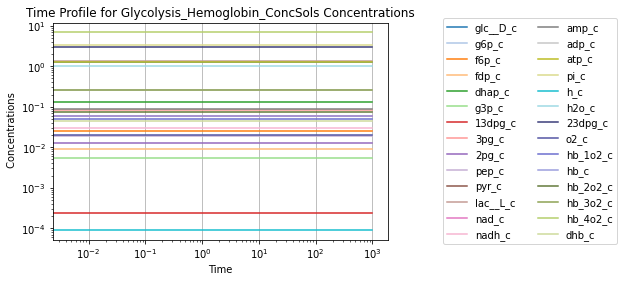

In [14]:
glyc_hb = glycolysis.merge(hemoglobin, inplace=False)

# Setup simulation object, ensure model is at steady state
sim = Simulation(glyc_hb, verbose=True)
sim.find_steady_state(glyc_hb, strategy="simulate", update_values=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glyc_hb, time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

### Storing information and references
#### Compartment
Because the character "c" represents the cytosol compartment, it is recommended to define and set the compartment in the `MassModel.compartments` attribute.

In [15]:
hemoglobin.compartments = {"c": "Cytosol"}
print(hemoglobin.compartments)

{'c': 'Cytosol'}


#### Units
All of the units for the numerical values used in this model are "Millimoles" for amount and "Liters" for volume (giving a concentration unit of 'Millimolar'), and "Hours" for time. In order to ensure that future users understand the numerical values for model, it is important to define the `MassModel.units` attribute.

The `MassModel.units` is a `cobra.DictList` that contains only `UnitDefinition` objects from the `mass.core.unit` submodule. Each `UnitDefinition` is created from `Unit` objects representing the base units that comprise the `UnitDefinition`. These `Units` are stored in the `list_of_units` attribute. Pre-built units can be viewed using the `print_defined_unit_values` function from the `mass.core.unit` submodule. Alternatively, custom units can also be created using the `UnitDefinition.create_unit` method. For more information about units, please see the module docstring for `mass.core.unit` submodule.

__Note:__ It is important to note that this attribute will NOT track units, but instead acts as a reference for the user and others so that they can perform necessary unit conversions.

In [16]:
# Using pre-build units to define UnitDefinitions
concentration = UnitDefinition("mM", name="Millimolar",
                               list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

# Add units to model
hemoglobin.add_units([concentration, time])
print(hemoglobin.units)

[<UnitDefinition Millimolar "mM" at 0x7f9d473a5d90>, <UnitDefinition hour "hr" at 0x7f9d474a9f50>]


## Export

After validation, the model is ready to be saved. The model can either be exported as a ".json" file or as an ".sbml" (".xml") file using their repsective submodules in `mass.io`.

To export the model, only the path to the directory and the model object itself need to be specified.

### Export using SBML

In [17]:
sbml.write_sbml_model(mass_model=hemoglobin, filename="SB2_" + hemoglobin.id + ".xml")

### Export using JSON

In [18]:
json.save_json_model(mass_model=hemoglobin, filename="SB2_" + hemoglobin.id + ".json")